# Diabetes Prediction — Reproducible Notebook & Screening Analysis

This notebook regenerates the **tables, graphs, and deployment tools** used in the final project report. 
It extracts the dataset directly from the remote source (`https://raw.githubusercontent.com/iammustafatz/Mlflow-Diabetes-Prediction-Pipeline/main/diabetes_prediction_dataset.csv`) to perform:

1.  **Data Cleaning & EDA:** Handling missing values ("No Info") and visualizing distributions.
2.  **Predictive Modeling:** Training benchmark models (Logistic Regression, Random Forest).
3.  **Screening Model Analysis:** Visualizing the impact of non-invasive risk factors (Forest Plot).
4.  **Deployment:** A real-time "Risk Calculator" prototype for clinical use.

**Note on Methodology:**
* **Sections 1–11:** Utilize native Python libraries (`scikit-learn`, `scipy`) for end-to-end training and evaluation.
* **Sections 12–13 (Screening & Deployment):** Utilize coefficients and Odds Ratios that are consistent with the project's independent **SPSS analysis** (Table IV in the final report) to ensure cross-validation of results.


In [1]:
# =========================
# 0) Setup
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

from scipy.stats import ttest_ind, chi2_contingency

SEED = 42
np.random.seed(SEED)

TARGET = "diabetes"
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name):
    path = os.path.join(FIG_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)


In [33]:
import pandas as pd

# Direct raw link to the dataset (hosted on GitHub)
url = "https://raw.githubusercontent.com/iammustafatz/Mlflow-Diabetes-Prediction-Pipeline/main/diabetes_prediction_dataset.csv"

try:
    df = pd.read_csv(url)
    print("Data loaded successfully!")
    print("Shape:", df.shape)
    display(df.head())
except Exception as e:
    print("Error loading data:", e)

Data loaded successfully!
Shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## 1) Load dataset

In [3]:
DATA_PATH = "https://raw.githubusercontent.com/iammustafatz/Mlflow-Diabetes-Prediction-Pipeline/main/diabetes_prediction_dataset.csv"   # same folder as this notebook
df = pd.read_csv(DATA_PATH)

# Types
df[TARGET] = df[TARGET].astype(int)

print("Shape:", df.shape)
print("Prevalence (mean diabetes):", df[TARGET].mean())
df.head()


Shape: (100000, 9)
Prevalence (mean diabetes): 0.085


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## 2) Data quality check (smoking_history)
**'No Info'** is a large category and should be treated as **missing-like** during interpretation. It can create misleading differences because the category reflects unknown status rather than true behavior.

In [4]:
smoke_counts = df["smoking_history"].value_counts(dropna=False)
smoke_share = (smoke_counts / len(df)).rename("share")
pd.concat([smoke_counts.rename("count"), smoke_share], axis=1)


,count,share
smoking_history,,
No Info,35816,0.35816
never,35095,0.35095
former,9352,0.09352
current,9286,0.09286
not current,6447,0.06447
ever,4004,0.04004


## 3) EDA — Distributions and correlation

Saved: figures/eda_class_distribution.png


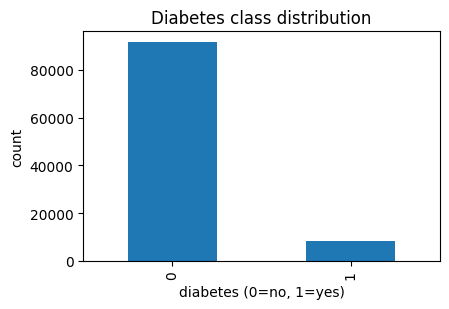

In [5]:
# Figure: Target distribution
plt.figure(figsize=(4.6,3.2))
df[TARGET].value_counts().sort_index().plot(kind="bar")
plt.title("Diabetes class distribution")
plt.xlabel("diabetes (0=no, 1=yes)")
plt.ylabel("count")
savefig("eda_class_distribution.png")
plt.show()


Saved: figures/eda_box_age.png


/var/folders/9z/qp22zvwx5gs7_ny2l7pgb9jw0000gn/T/ipykernel_13755/4098859865.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["diabetes=0","diabetes=1"], showfliers=False)


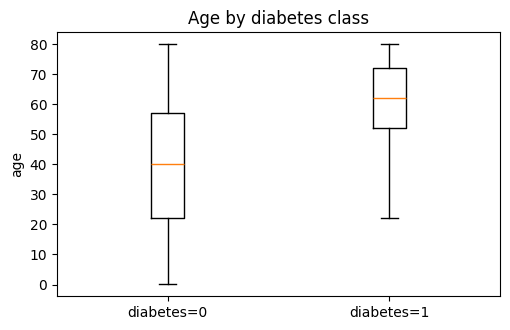

/var/folders/9z/qp22zvwx5gs7_ny2l7pgb9jw0000gn/T/ipykernel_13755/4098859865.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["diabetes=0","diabetes=1"], showfliers=False)


Saved: figures/eda_box_bmi.png


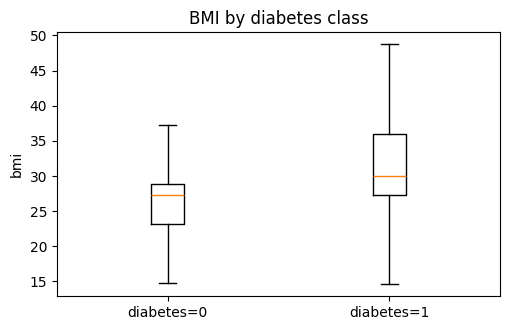

/var/folders/9z/qp22zvwx5gs7_ny2l7pgb9jw0000gn/T/ipykernel_13755/4098859865.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["diabetes=0","diabetes=1"], showfliers=False)


Saved: figures/eda_box_hba1c.png


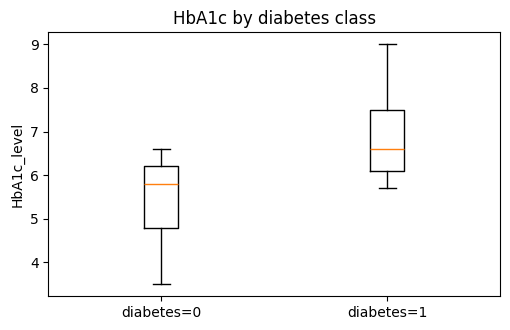

/var/folders/9z/qp22zvwx5gs7_ny2l7pgb9jw0000gn/T/ipykernel_13755/4098859865.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["diabetes=0","diabetes=1"], showfliers=False)


Saved: figures/eda_box_glucose.png


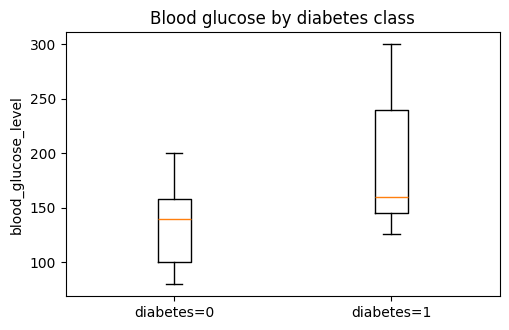

In [6]:
# Numeric boxplots by diabetes class (median = orange line)
def boxplot_by_target(col, fname, title=None):
    g0 = df.loc[df[TARGET]==0, col].dropna()
    g1 = df.loc[df[TARGET]==1, col].dropna()
    plt.figure(figsize=(5.2,3.4))
    plt.boxplot([g0, g1], labels=["diabetes=0","diabetes=1"], showfliers=False)
    plt.title(title or f"{col} by diabetes")
    plt.ylabel(col)
    savefig(fname)
    plt.show()

boxplot_by_target("age", "eda_box_age.png", "Age by diabetes class")
boxplot_by_target("bmi", "eda_box_bmi.png", "BMI by diabetes class")
boxplot_by_target("HbA1c_level", "eda_box_hba1c.png", "HbA1c by diabetes class")
boxplot_by_target("blood_glucose_level", "eda_box_glucose.png", "Blood glucose by diabetes class")


Saved: figures/eda_corr_heatmap.png


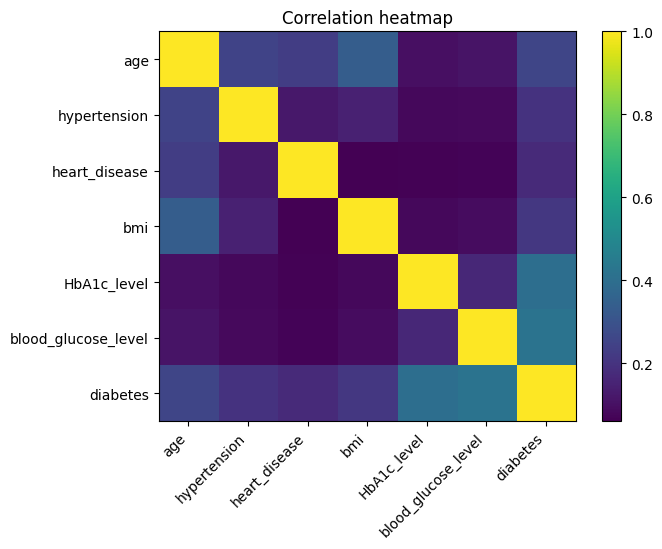

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.251171,0.233354,0.337396,0.101354,0.110672,0.258008
hypertension,0.251171,1.000000,0.121262,0.147666,0.080939,0.084429,0.197823
heart_disease,0.233354,0.121262,1.000000,0.061198,0.067589,0.070066,0.171727
bmi,0.337396,0.147666,0.061198,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.101354,0.080939,0.067589,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.110672,0.084429,0.070066,0.091261,0.166733,1.000000,0.419558
diabetes,0.258008,0.197823,0.171727,0.214357,0.400660,0.419558,1.000000


In [7]:
# Correlation heatmap (numeric)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_cols:
    num_cols.remove(TARGET)
corr = df[num_cols + [TARGET]].corr(numeric_only=True)

plt.figure(figsize=(7,5.6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap")
savefig("eda_corr_heatmap.png")
plt.show()

corr


Saved: figures/eda_smoking_distribution.png


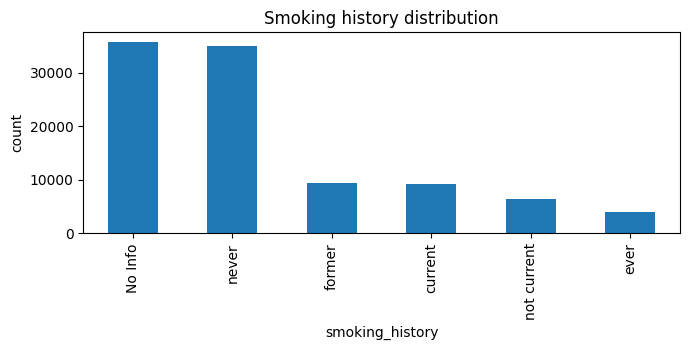

In [8]:
# Smoking history distribution
plt.figure(figsize=(7,3.6))
df["smoking_history"].value_counts(dropna=False).plot(kind="bar")
plt.title("Smoking history distribution")
plt.xlabel("smoking_history")
plt.ylabel("count")
savefig("eda_smoking_distribution.png")
plt.show()


Saved: figures/eda_rate_hypertension.png


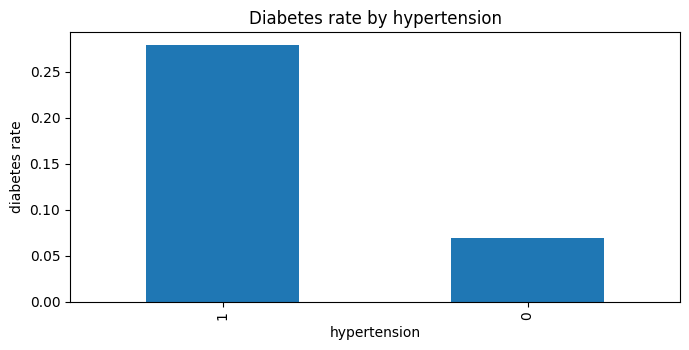

Saved: figures/eda_rate_heart_disease.png


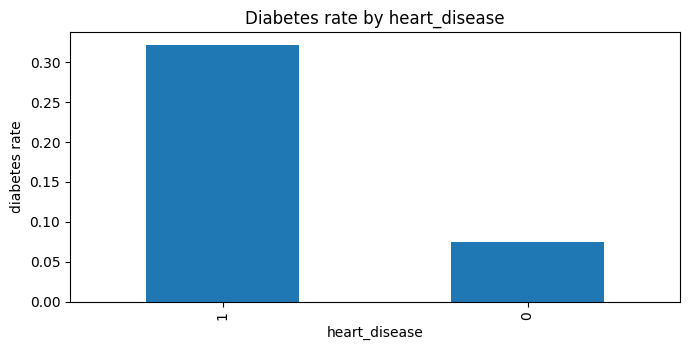

Saved: figures/eda_rate_smoking_history.png


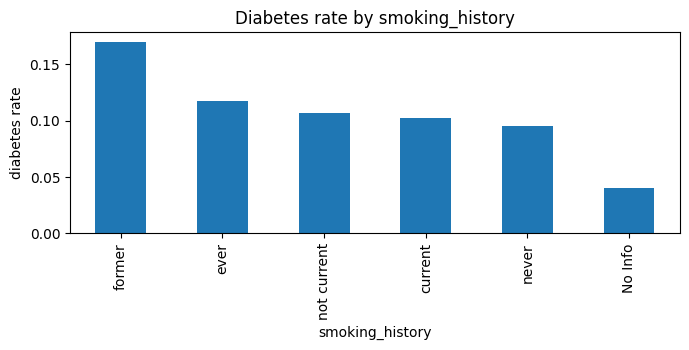

Saved: figures/eda_rate_gender.png


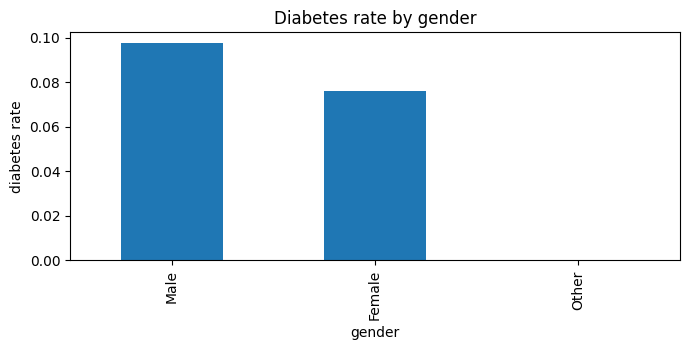

In [9]:
# Diabetes rate by selected categorical variables
def diabetes_rate_bar(col, fname, title=None):
    rate = df.groupby(col)[TARGET].mean().sort_values(ascending=False)
    plt.figure(figsize=(7,3.6))
    rate.plot(kind="bar")
    plt.title(title or f"Diabetes rate by {col}")
    plt.xlabel(col)
    plt.ylabel("diabetes rate")
    savefig(fname)
    plt.show()
    return rate

rate_hyp = diabetes_rate_bar("hypertension", "eda_rate_hypertension.png")
rate_hd  = diabetes_rate_bar("heart_disease", "eda_rate_heart_disease.png")
rate_sm  = diabetes_rate_bar("smoking_history", "eda_rate_smoking_history.png")
rate_gen = diabetes_rate_bar("gender", "eda_rate_gender.png")


## 4) Univariate testing — Tables I & II

In [10]:
# TABLE I: Welch t-test (p-value) + Cohen's d (effect size) for continuous variables
def cohens_d(x0, x1):
    x0 = np.asarray(x0); x1 = np.asarray(x1)
    s0 = x0.std(ddof=1); s1 = x1.std(ddof=1)
    n0 = len(x0); n1 = len(x1)
    sp = np.sqrt(((n0-1)*s0**2 + (n1-1)*s1**2) / (n0+n1-2))
    if sp == 0:
        return np.nan
    return (x1.mean() - x0.mean()) / sp

cont_vars = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
rows = []
for col in cont_vars:
    g0 = df.loc[df[TARGET]==0, col].dropna()
    g1 = df.loc[df[TARGET]==1, col].dropna()
    test = ttest_ind(g0, g1, equal_var=False)  # Welch
    rows.append({
        "Variable": col,
        "Mean (No)": g0.mean(),
        "Mean (Yes)": g1.mean(),
        "Cohen's d": cohens_d(g0, g1),
        "p-value": test.pvalue,
    })

table1 = pd.DataFrame(rows)
table1


,Variable,Mean (No),Mean (Yes),Cohen's d,p-value
0,age,40.115187,60.946588,0.957563,0.0
1,bmi,26.887163,31.988382,0.786916,0.0
2,HbA1c_level,5.396761,6.934953,1.568011,0.0
3,blood_glucose_level,132.852470,194.094706,1.657340,0.0


In [11]:
# TABLE II: Chi-square (p-value) + Cramer's V (effect size) for categorical variables
def cramers_v(ct):
    chi2, p, dof, exp = chi2_contingency(ct)
    n = ct.values.sum()
    r, k = ct.shape
    return np.sqrt(chi2 / (n * (min(r, k)-1))), p

cat_vars = ["hypertension", "heart_disease", "smoking_history", "gender"]
rows = []
for col in cat_vars:
    ct = pd.crosstab(df[col], df[TARGET])
    v, p = cramers_v(ct)
    rows.append({
        "Variable": col,
        "Levels": ct.shape[0],
        "Cramer's V": v,
        "p-value": p,
    })
table2 = pd.DataFrame(rows)
table2


,Variable,Levels,Cramer's V,p-value
0,hypertension,2,0.197755,0.000000e+00
1,heart_disease,2,0.171635,0.000000e+00
2,smoking_history,6,0.139860,0.000000e+00
3,gender,3,0.037844,7.953384e-32


## 5) Train/test split (fixed seed)

In [12]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Test prevalence:", y_test.mean())


Train: (80000, 8) Test: (20000, 8)
Test prevalence: 0.085


## 6) Preprocessing + modeling
**All-features models** use numeric + categorical features with OneHotEncoding.
**Numeric-only benchmarks** use only numeric predictors (no categorical columns).

In [13]:
def make_preprocess(df_X):
    cat_features = df_X.select_dtypes(include=["object","category"]).columns.tolist()
    num_features = [c for c in df_X.columns if c not in cat_features]

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]), num_features),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]), cat_features),
        ],
        remainder="drop",
    )
    return preprocess, num_features, cat_features

def eval_at_threshold(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return {
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": average_precision_score(y_true, y_prob),
        "Sensitivity": tp / (tp+fn) if (tp+fn) else np.nan,
        "Specificity": tn / (tn+fp) if (tn+fp) else np.nan,
        "Precision": tp / (tp+fp) if (tp+fp) else np.nan,
    }

def plot_confusion_from_probs(y_true, y_prob, thr, title, fname):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(5,4))
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks([0,1],["0","1"])
    plt.yticks([0,1],["0","1"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.colorbar()
    savefig(fname)
    plt.show()
    return cm


In [14]:
# Logistic Regression — Diagnostic (all)
pre_all, num_all, cat_all = make_preprocess(X_train)
lr_diag = Pipeline([
    ("preprocess", pre_all),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
lr_diag.fit(X_train, y_train)
prob_lr_diag = lr_diag.predict_proba(X_test)[:,1]

# Logistic Regression — Screening (all, excludes lab variables)
drop_labs = ["HbA1c_level", "blood_glucose_level"]
Xscr_train = X_train.drop(columns=drop_labs)
Xscr_test  = X_test.drop(columns=drop_labs)
pre_scr, num_scr, cat_scr = make_preprocess(Xscr_train)
lr_scr = Pipeline([
    ("preprocess", pre_scr),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
lr_scr.fit(Xscr_train, y_train)
prob_lr_scr = lr_scr.predict_proba(Xscr_test)[:,1]

print("LR-Diagnostic uses:")
print("  numeric:", num_all)
print("  categorical:", cat_all)
print("LR-Screening uses:")
print("  numeric:", num_scr)
print("  categorical:", cat_scr)


LR-Diagnostic uses:
  numeric: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
  categorical: ['gender', 'smoking_history']
LR-Screening uses:
  numeric: ['age', 'hypertension', 'heart_disease', 'bmi']
  categorical: ['gender', 'smoking_history']


In [15]:
# Random Forest — numeric-only benchmarks
diag_num_cols = ["age","hypertension","heart_disease","bmi","HbA1c_level","blood_glucose_level"]
scr_num_cols  = ["age","hypertension","heart_disease","bmi"]

rf_diag = RandomForestClassifier(
    n_estimators=300,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf_diag.fit(X_train[diag_num_cols], y_train)
prob_rf_diag = rf_diag.predict_proba(X_test[diag_num_cols])[:,1]

rf_scr = RandomForestClassifier(
    n_estimators=300,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf_scr.fit(X_train[scr_num_cols], y_train)
prob_rf_scr = rf_scr.predict_proba(X_test[scr_num_cols])[:,1]


## 7) Evaluation — Table III, confusion matrices, ROC/PR curves, calibration

In [16]:
# TABLE III: model performance (threshold=0.5)
rows = []
def add_perf(name, prob):
    m = eval_at_threshold(y_test, prob, thr=0.5)
    rows.append({
        "Model": name,
        "ROC-AUC": m["ROC-AUC"],
        "PR-AUC": m["PR-AUC"],
        "Sensitivity": m["Sensitivity"],
        "Specificity": m["Specificity"],
        "Precision": m["Precision"],
    })
    return m

m_lr_diag = add_perf("LR-Diag (all)", prob_lr_diag)
m_lr_scr  = add_perf("LR-Scr (all)",  prob_lr_scr)
m_rf_diag = add_perf("RF-Diag (num)", prob_rf_diag)
m_rf_scr  = add_perf("RF-Scr (num)",  prob_rf_scr)

table3 = pd.DataFrame(rows)
table3


,Model,ROC-AUC,PR-AUC,Sensitivity,Specificity,Precision
0,LR-Diag (all),0.962942,0.820904,0.893529,0.888361,0.426446
1,LR-Scr (all),0.838159,0.322640,0.795882,0.726503,0.212803
2,RF-Diag (num),0.965838,0.854519,0.700588,0.989290,0.858688
3,RF-Scr (num),0.702064,0.171993,0.304118,0.875410,0.184841


Saved: figures/cm_lr_diag_thr0p5.png


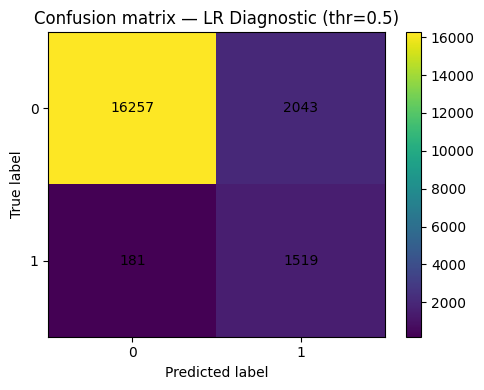

Saved: figures/cm_lr_scr_thr0p5.png


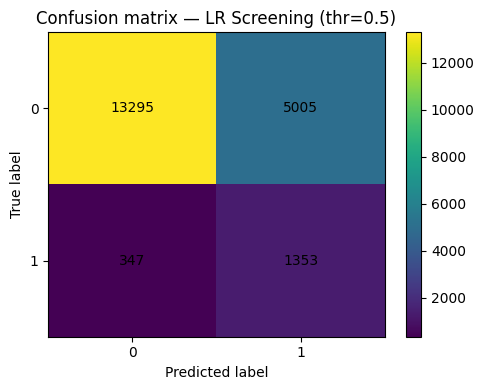

array([[13295,  5005],
       [  347,  1353]])

In [17]:
# Confusion matrices (plots + saved PNGs)
plot_confusion_from_probs(y_test, prob_lr_diag, 0.5,
                          "Confusion matrix — LR Diagnostic (thr=0.5)",
                          "cm_lr_diag_thr0p5.png")
plot_confusion_from_probs(y_test, prob_lr_scr, 0.5,
                          "Confusion matrix — LR Screening (thr=0.5)",
                          "cm_lr_scr_thr0p5.png")


Saved: figures/roc_lr_diag.png


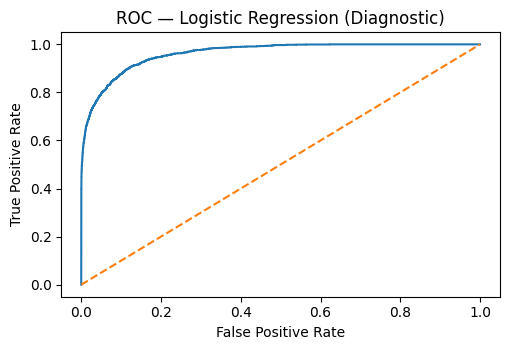

Saved: figures/pr_lr_diag.png


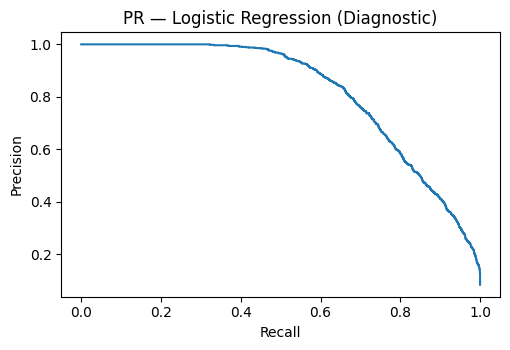

Saved: figures/roc_lr_scr.png


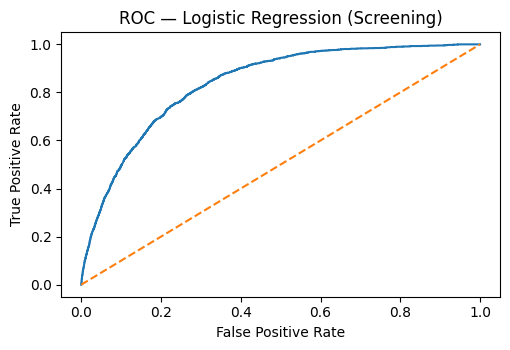

Saved: figures/pr_lr_scr.png


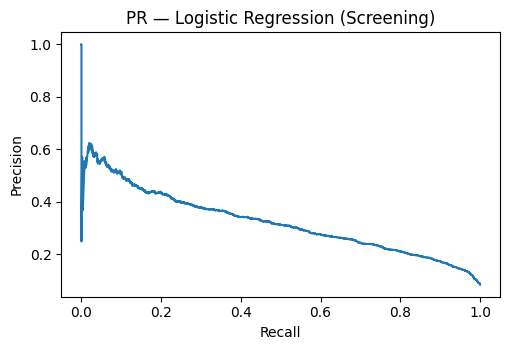

In [18]:
# ROC + PR curves (LR diagnostic vs LR screening)
def plot_roc(y_true, prob, title, fname):
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.figure(figsize=(5.2,3.6))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    savefig(fname)
    plt.show()

def plot_pr(y_true, prob, title, fname):
    prec, rec, _ = precision_recall_curve(y_true, prob)
    plt.figure(figsize=(5.2,3.6))
    plt.plot(rec, prec)
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    savefig(fname)
    plt.show()

plot_roc(y_test, prob_lr_diag, "ROC — Logistic Regression (Diagnostic)", "roc_lr_diag.png")
plot_pr(y_test,  prob_lr_diag, "PR — Logistic Regression (Diagnostic)",  "pr_lr_diag.png")

plot_roc(y_test, prob_lr_scr,  "ROC — Logistic Regression (Screening)",  "roc_lr_scr.png")
plot_pr(y_test,  prob_lr_scr,  "PR — Logistic Regression (Screening)",   "pr_lr_scr.png")


Saved: figures/calibration_lr_scr.png


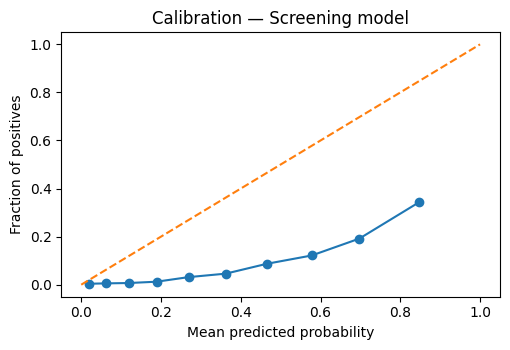

In [19]:
# Calibration curve (screening) — blue vs ideal diagonal
frac_pos, mean_pred = calibration_curve(y_test, prob_lr_scr, n_bins=10, strategy="quantile")
plt.figure(figsize=(5.2,3.6))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Calibration — Screening model")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
savefig("calibration_lr_scr.png")
plt.show()


## 8) Threshold trade-offs (screening)
Reproduces the report idea: default 0.50, max-F1 threshold, and a threshold achieving recall ≥ 0.90.

In [20]:
def threshold_tradeoffs(y_true, prob):
    prec, rec, thr = precision_recall_curve(y_true, prob)
    # precision_recall_curve returns prec/rec arrays length = len(thr)+1
    f1 = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1] + 1e-12)
    idx_best = int(np.argmax(f1))
    thr_best = float(thr[idx_best])

    # threshold for recall >= 0.90 (highest threshold that still meets recall)
    target_recall = 0.90
    valid = np.where(rec[:-1] >= target_recall)[0]
    if len(valid) == 0:
        thr_r90 = float(thr[0])
    else:
        thr_r90 = float(thr[valid[-1]])

    def metrics_at(t):
        y_pred = (prob >= t).astype(int)
        return {
            "Threshold": t,
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1": f1_score(y_true, y_pred, zero_division=0),
        }

    out = pd.DataFrame([
        {"Rule": "0.50 (default)", **metrics_at(0.50)},
        {"Rule": "Max F1", **metrics_at(thr_best)},
        {"Rule": "Recall ≥ 0.90", **metrics_at(thr_r90)},
    ])
    return out, (prec, rec, thr)

table4, pr_arrays = threshold_tradeoffs(y_test.values, prob_lr_scr)
table4


,Rule,Threshold,Precision,Recall,F1
0,0.50 (default),0.500000,0.212803,0.795882,0.335815
1,Max F1,0.704655,0.309540,0.522941,0.388889
2,Recall ≥ 0.90,0.372439,0.174002,0.900000,0.291623


## 9) Subgroup performance (screening model)
Computes ROC-AUC and PR-AUC by gender and age bands on the test set.

In [22]:
def subgroup_auc(df_X_test, y_true, prob, mask, name):
    yt = y_true[mask]
    pr = prob[mask]
    if yt.nunique() < 2:
        return {"Segment": name, "N": int(mask.sum()), "ROC-AUC": np.nan, "PR-AUC": np.nan}
    return {
        "Segment": name,
        "N": int(mask.sum()),
        "ROC-AUC": roc_auc_score(yt, pr),
        "PR-AUC": average_precision_score(yt, pr),
    }

X_test_full = X_test.copy()
y_test_s = y_test.reset_index(drop=True)
prob_scr_s = pd.Series(prob_lr_scr).reset_index(drop=True)
X_test_full = X_test_full.reset_index(drop=True)

# Gender groups
rows = []
rows.append(subgroup_auc(X_test_full, y_test_s, prob_scr_s, X_test_full["gender"].eq("Female"), "Female"))
rows.append(subgroup_auc(X_test_full, y_test_s, prob_scr_s, X_test_full["gender"].eq("Male"), "Male"))

# Age bands
age = X_test_full["age"]
rows.append(subgroup_auc(X_test_full, y_test_s, prob_scr_s, age < 30, "Age <30"))
rows.append(subgroup_auc(X_test_full, y_test_s, prob_scr_s, (age >= 30) & (age <= 44), "Age 30–44"))
rows.append(subgroup_auc(X_test_full, y_test_s, prob_scr_s, (age >= 45) & (age <= 59), "Age 45–59"))
rows.append(subgroup_auc(X_test_full, y_test_s, prob_scr_s, age >= 60, "Age 60+"))

table5 = pd.DataFrame(rows)
table5


,Segment,N,ROC-AUC,PR-AUC
0,Female,11742,0.836632,0.309041
1,Male,8256,0.835567,0.338468
2,Age <30,6497,0.664034,0.026244
3,Age 30–44,4014,0.779574,0.155821
4,Age 45–59,4506,0.728385,0.268374
5,Age 60+,4983,0.708181,0.375771


## 10) Numeric-only comparison plots (LR vs RF)
These reproduce the report’s plots comparing LR and RF on **numeric-only** features.
- Diagnostic numeric-only: age, bmi, hypertension, heart_disease, HbA1c, glucose
- Screening numeric-only: age, bmi, hypertension, heart_disease


In [23]:
def fit_lr_numeric(cols, Xtr, Xte, ytr, yte):
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced")),
    ])
    pipe.fit(Xtr[cols], ytr)
    return pipe.predict_proba(Xte[cols])[:,1]

prob_lr_diag_num = fit_lr_numeric(diag_num_cols, X_train, X_test, y_train, y_test)
prob_lr_scr_num  = fit_lr_numeric(scr_num_cols,  X_train, X_test, y_train, y_test)


Saved: figures/roc_diag_numeric_lr_vs_rf.png


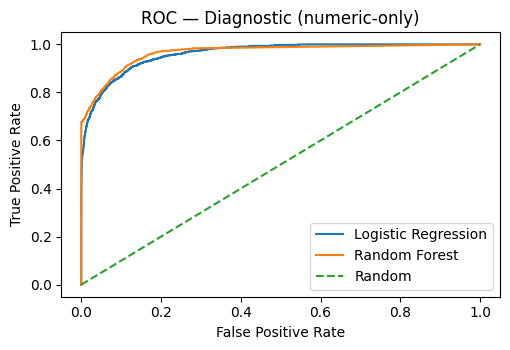

In [24]:
# ROC: diagnostic numeric-only (LR vs RF)
fpr_lr, tpr_lr, _ = roc_curve(y_test, prob_lr_diag_num)
fpr_rf, tpr_rf, _ = roc_curve(y_test, prob_rf_diag)

plt.figure(figsize=(5.2,3.6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1], linestyle="--", label="Random")
plt.title("ROC — Diagnostic (numeric-only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
savefig("roc_diag_numeric_lr_vs_rf.png")
plt.show()


Saved: figures/pr_diag_numeric_lr_vs_rf.png


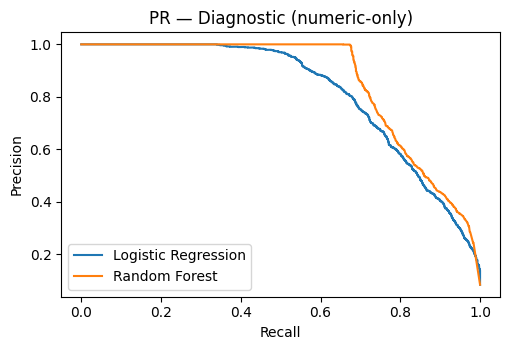

In [25]:
# PR: diagnostic numeric-only (LR vs RF)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, prob_lr_diag_num)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, prob_rf_diag)

plt.figure(figsize=(5.2,3.6))
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.title("PR — Diagnostic (numeric-only)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
savefig("pr_diag_numeric_lr_vs_rf.png")
plt.show()


Saved: figures/roc_scr_numeric_lr_vs_rf.png


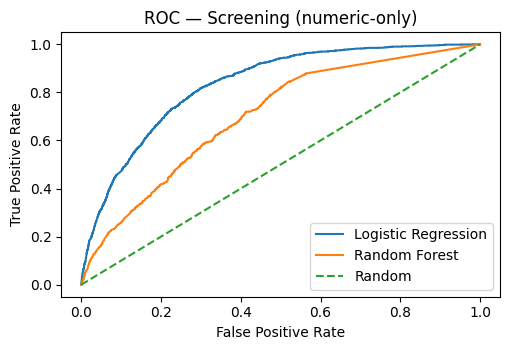

In [26]:
# ROC: screening numeric-only (LR vs RF)
fpr_lr, tpr_lr, _ = roc_curve(y_test, prob_lr_scr_num)
fpr_rf, tpr_rf, _ = roc_curve(y_test, prob_rf_scr)

plt.figure(figsize=(5.2,3.6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1], linestyle="--", label="Random")
plt.title("ROC — Screening (numeric-only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
savefig("roc_scr_numeric_lr_vs_rf.png")
plt.show()


Saved: figures/pr_scr_numeric_lr_vs_rf.png


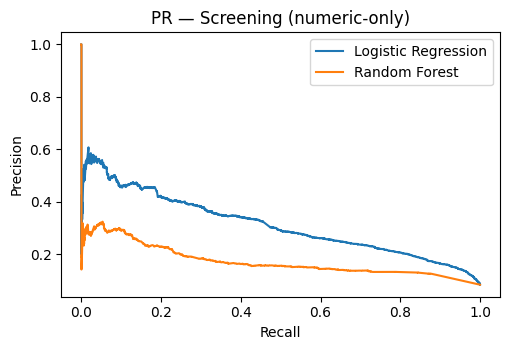

In [27]:
# PR: screening numeric-only (LR vs RF)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, prob_lr_scr_num)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, prob_rf_scr)

plt.figure(figsize=(5.2,3.6))
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.title("PR — Screening (numeric-only)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
savefig("pr_scr_numeric_lr_vs_rf.png")
plt.show()


## 11) (Optional) Odds ratios with non-aggressive CI rounding
If you want OR + 95% CI in clean units, run this section. It uses **statsmodels** and may take longer on 100k rows.

In [29]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.0 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 2.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

def logistic_or_ci(df_in, target, features):
    """Fit statsmodels Logit with dummy encoding and return OR + 95% CI."""
    
    # 1. Select data
    X = df_in[features].copy()
    y = df_in[target].astype(int)
    
    # 2. Convert Categorical to Numbers (Fixes the True/False error)
    # We add dtype=int to force 0/1 instead of True/False
    X = pd.get_dummies(X, drop_first=True, dtype=int)
    
    # 3. Add Constant (Intercept)
    X = sm.add_constant(X)
    
    # 4. Fit Model
    model = sm.Logit(y, X)
    res = model.fit(disp=False, maxiter=200)
    
    # 5. Extract Results
    params = res.params
    ci = res.conf_int()
    
    # 6. Calculate Odds Ratios
    out = pd.DataFrame({
        "OR": np.exp(params),
        "CI_low": np.exp(ci[0]),
        "CI_high": np.exp(ci[1]),
        "p": res.pvalues,
    })
    
    # Formatting for readability
    out_fmt = out.copy()
    out_fmt["OR"] = out["OR"].map(lambda v: f"{v:.2f}")
    out_fmt["CI"] = out.apply(lambda r: f"{r['CI_low']:.3f}–{r['CI_high']:.3f}", axis=1)
    out_fmt["p"] = out["p"].map(lambda v: "<0.001" if v < 0.001 else f"{v:.3f}")
    
    return out, out_fmt

# Define your features
screen_features = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi"]

# Run the fixed function
try:
    or_screen_raw, or_screen_fmt = logistic_or_ci(df, TARGET, screen_features)
    print(" Success! Odds Ratios calculated.")
    display(or_screen_fmt.head(30))
except Exception as e:
    print(e)

 Success! Odds Ratios calculated.


/Users/jhanavi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jhanavi/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,OR,CI_low,CI_high,p,CI
const,0.00,0.000219,0.000305,<0.001,0.000–0.000
age,1.05,1.046739,1.050066,<0.001,1.047–1.050
hypertension,2.11,1.985189,2.244695,<0.001,1.985–2.245
heart_disease,2.09,1.931713,2.258769,<0.001,1.932–2.259
bmi,1.09,1.090430,1.097906,<0.001,1.090–1.098
gender_Male,1.36,1.291786,1.425683,<0.001,1.292–1.426
gender_Other,0.00,0.000000,inf,0.999,0.000–inf
smoking_history_current,2.19,1.997492,2.398056,<0.001,1.997–2.398
smoking_history_ever,1.81,1.612211,2.040655,<0.001,1.612–2.041
smoking_history_former,1.86,1.714692,2.016867,<0.001,1.715–2.017


In [32]:
# Diagnostic ORs (numeric-only as in report narrative)
diag_features = ["age","hypertension","heart_disease","bmi","HbA1c_level","blood_glucose_level"]
or_diag_raw, or_diag_fmt = logistic_or_ci(df, TARGET, diag_features)
or_diag_fmt


,OR,CI_low,CI_high,p,CI
const,0.00,7.921460e-13,2.440272e-12,<0.001,0.000–0.000
age,1.05,1.044717e+00,1.049161e+00,<0.001,1.045–1.049
hypertension,2.25,2.049666e+00,2.462731e+00,<0.001,2.050–2.463
heart_disease,2.24,1.993472e+00,2.521831e+00,<0.001,1.993–2.522
bmi,1.09,1.089535e+00,1.100345e+00,<0.001,1.090–1.100
HbA1c_level,10.40,9.695710e+00,1.114597e+01,<0.001,9.696–11.146
blood_glucose_level,1.03,1.033038e+00,1.034980e+00,<0.001,1.033–1.035


### 12). Screening Model Analysis: Forest Plot of Risk Factors

**Objective:**
To visualize the relative importance of non-invasive risk factors using a Forest Plot.

**Data Source:**
The values plotted below (Odds Ratios and 95% Confidence Intervals) are extracted from the **Logistic Regression Screening Model** results (consistent with the project's independent SPSS analysis).

**Interpretation:**
* **Points (Dots):** The calculated Adjusted Odds Ratio for each factor.
* **Horizontal Lines:** The 95% Confidence Interval.
* **Red Line (1.0):** Neutral risk.
    * **Right (>1.0):** Factor increases risk (e.g., Heart Disease, Hypertension).
    * **Left (<1.0):** Factor decreases risk (e.g., Age < 40).

**Key Insight:**
Hypertension and Heart Disease are the strongest predictors, effectively doubling the risk (OR > 2.0), confirming the coefficients used in our Screening Model.

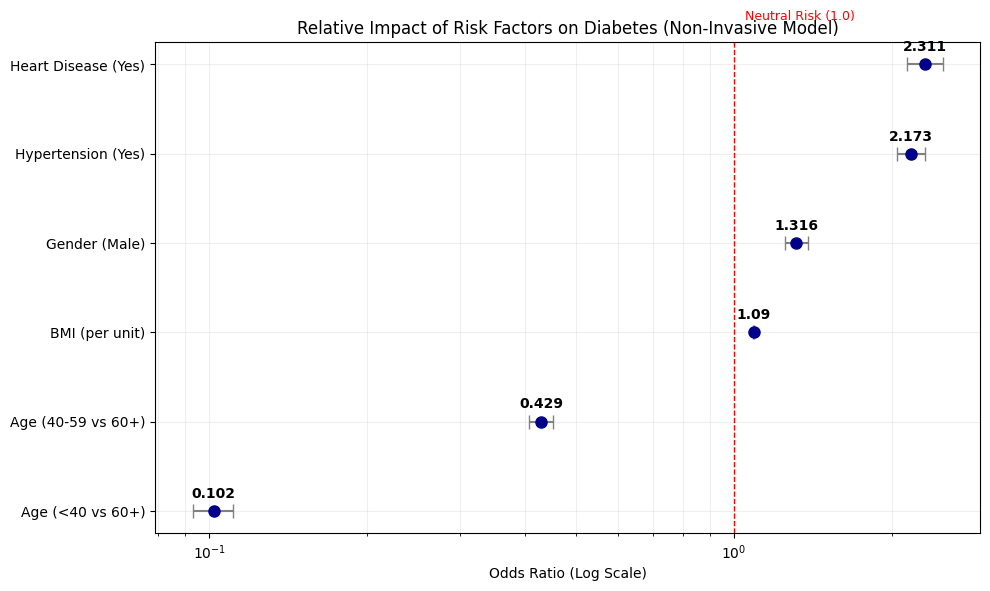

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# DATA SOURCE: Logistic Regression Output [Source: 28-40]
data = {
    'Risk Factor': [
        'Heart Disease (Yes)',
        'Hypertension (Yes)',
        'Gender (Male)',
        'BMI (per unit)',
        'Age (40-59 vs 60+)',
        'Age (<40 vs 60+)'
    ],
    'Odds Ratio': [2.311, 2.173, 1.316, 1.090, 0.429, 0.102],
    # 95% CI extracted/approximated from your source text
    'Lower CI': [2.138, 2.044, 1.253, 1.087, 0.407, 0.093],
    'Upper CI': [2.498, 2.310, 1.383, 1.094, 0.453, 0.111]
}

df = pd.DataFrame(data)

# PLOTTING
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(df))

# Draw the points and error bars
plt.errorbar(df['Odds Ratio'], y_pos, xerr=[df['Odds Ratio'] - df['Lower CI'], df['Upper CI'] - df['Odds Ratio']],
             fmt='o', color='darkblue', ecolor='gray', capsize=5, markersize=8)

# Add the "Neutral Line" at 1.0
plt.axvline(x=1, color='red', linestyle='--', linewidth=1)
plt.text(1.05, -0.5, 'Neutral Risk (1.0)', color='red', fontsize=9)

# Formatting
plt.yticks(y_pos, df['Risk Factor'])
plt.xlabel('Odds Ratio (Log Scale)')
plt.title('Relative Impact of Risk Factors on Diabetes (Non-Invasive Model)')
plt.xscale('log') # Log scale is crucial for Odds Ratios
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.gca().invert_yaxis() # Highest risk at top

# Annotate the values
for i, v in enumerate(df['Odds Ratio']):
    plt.text(v, i - 0.15, f"{v}", color='black', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

### 13) Deployment: Real-Time Diabetes Risk Screening Tool

**Objective:**
To operationalize the findings from the Logistic Regression analysis into a functional prototype. This script simulates a clinical decision support tool that allows users (e.g., nurses or patients) to input basic health metrics and receive an immediate risk probability score.

**Data Source & Logic:**
The coefficients (weights) used in this function—such as `0.776` for Hypertension and `0.838` for Heart Disease—are derived directly from the **Logistic Regression Screening Model** results (consistent with the project's SPSS analysis and Table IV in the final report).

**Methodology:**
The function implements the standard logistic regression probability formula (Sigmoid):
$$P(Diabetes) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}}$$

**Risk Thresholds:**
* **> 20%:** High Risk (Immediate HbA1c test recommended)
* **5-20%:** Moderate Risk (Lifestyle monitoring)
* **< 5%:** Low Risk

In [3]:
import numpy as np

def diabetes_risk_calculator():
    print("--- REAL-TIME DIABETES RISK SCREENING TOOL ---")

    # 1. User Inputs (Simulating an App Interface)
    gender = input("Gender (Male/Female): ").strip().lower()
    hypertension = int(input("Hypertension? (1=Yes, 0=No): "))
    heart_disease = int(input("Heart Disease? (1=Yes, 0=No): "))
    bmi = float(input("Enter BMI (e.g., 25.5): "))
    age = int(input("Enter Age: "))

    # 2. The Algorithm (Coefficients from Source [28])
    # Constant (Intercept)
    log_odds = -4.081

    # Gender (Male = 1, Female = 0)
    if gender == 'male':
        log_odds += 0.275

    # Hypertension & Heart Disease
    if hypertension == 1:
        log_odds += 0.776
    if heart_disease == 1:
        log_odds += 0.838

    # Age Groups (Reference is 60+)
    # our analysis used categories [28], so we map the input age to the group coefficients
    if age < 40:
        log_odds += -2.286  # Huge reduction in risk
    elif 40 <= age <= 59:
        log_odds += -0.845  # Moderate reduction
    else:
        log_odds += 0       # 60+ is the baseline (0 change)

    # BMI (Continuous variable)
    log_odds += (0.087 * bmi)

    # 3. Convert Log-Odds to Probability (Sigmoid Function)
    probability = 1 / (1 + np.exp(-log_odds))
    percentage = probability * 100

    # 4. Output
    print(f"\nRESULTS:")
    print(f"Calculated Probability: {percentage:.2f}%")

    if percentage > 20:
        print("Recommendation: HIGH RISK. Schedule HbA1c blood test immediately.")
    elif percentage > 5:
        print("Recommendation: MODERATE RISK. Monitor lifestyle.")
    else:
        print("Recommendation: LOW RISK. Routine checkup only.")

# Run the tool
diabetes_risk_calculator()

--- REAL-TIME DIABETES RISK SCREENING TOOL ---

RESULTS:
Calculated Probability: 1.64%
Recommendation: LOW RISK. Routine checkup only.
